# 导包

In [13]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
# print(torch.__version__)
# print(torchvision.__version__)
# print(torch.cuda.is_available())
import numpy as np
import random
import matplotlib.pyplot as plt

In [79]:
def try_gpu():
    """If GPU is available, return torch.device as cuda:0; else return torch.device as cpu."""
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = try_gpu()
device

device(type='cpu')

# 卷积神经网络基础

## Cov2D
`torch.nn.Conv2D的输入形状是（batch_size, input_channels, height, weight）`

###  二维互相关运算
- Conv2D实际执行的是二维互相关运算。
- 二维互相关运算的核数组左右、上下翻转才是二维卷积运算。

In [6]:
def corr2d(X, K):
    """
    对二维特折X与核K进行卷积运算。
    
    :param X:二维输入特征（H,W） 
    :param K: 核数组（h,w）
    :return: 二维输出。
    """
    h, w = K.shape
    Y = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w] * K).sum()
    return Y

In [8]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = torch.tensor([[0, 1], [2, 3]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 无通道卷积层

In [10]:
class Conv2D(torch.nn.Module):
    """
    构造二维卷积层
    """
    def __init__(self, kernel_size):
        """
        构造二维卷积层
        :param kernel_size: 核大小(h,w)。
        """
        super(Conv2D, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(kernel_size))
        self.bias = torch.nn.Parameter(torch.randn(1))
        
    def forward(self, X):
        """
        前向运算，
        :param X: 二维输入特征（H,W）。
        :return: 二维输出。 
        """
        return corr2d(X, self.weight) + self.bias

### 卷积层学习

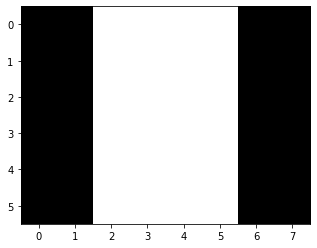

In [17]:
X = torch.ones(6, 8)
X[:, 2:6] = 0
plt.imshow(X.numpy(), cmap="gray_r")

In [18]:
K = torch.tensor([[1, -1]])
# 检测边缘算子

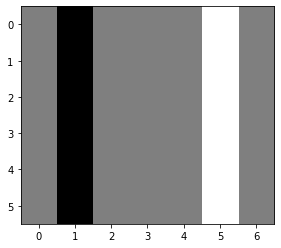

In [22]:
Y = corr2d(X, K)
plt.imshow(Y.numpy(), cmap="gray_r")

In [23]:
conv2d = Conv2D(kernel_size=(1, 2))
step, lr = 20, 0.01

for i in range(step):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y) ** 2).sum()
    l.backward()

    conv2d.weight.data -= lr * conv2d.weight.grad
    conv2d.bias.data -= lr * conv2d.bias.grad

    conv2d.weight.grad.fill_(0)
    conv2d.bias.grad.fill_(0)
    if (i + 1) % 5 == 0:
        print('Step %d, loss %.3f' % (i + 1, l.item()))

Step 5, loss 5.605
Step 10, loss 1.502
Step 15, loss 0.412
Step 20, loss 0.114


In [25]:
print("weight: ", conv2d.weight.data, K)
print("bias: ", conv2d.bias.data)

weight:  tensor([[ 0.9176, -0.9113]]) tensor([[ 1, -1]])
bias:  tensor([-0.0035])


## 特征图与感受野
- 特征图：二维卷积层的输出，也是一个二维数组；
- 感受野：影响元素x的前向计算的所有可能输入区域，堆叠Conv2D可以增大感受野。

## 填充padding与步幅stride
$${(H_Y, W_Y)} = \lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

### 填充
- 填充上下左右可以用不同的填充，但一般填充的数量一样。
- 卷积神经网络经常使用奇数高宽的卷积核，如1、3、5和7，所以两端上的填充个数相等，填充数量为$\frac{k-1}{2}$。

In [32]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
X = torch.rand(8, 8)
X = X.view((1, 1) + X.shape)
conv2d(X).shape[2:]

torch.Size([8, 8])

In [33]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5, 3), padding=(2, 1))
conv2d(X).shape[2:]

torch.Size([8, 8])

### 步幅
卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动，每次滑动的行数和列数称为步幅（stride）。

In [36]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, stride=2)
conv2d(X).shape[2:]

torch.Size([4, 4])

In [37]:
conv2d = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 5), padding=(0, 1), stride=(3,4))
conv2d(X).shape[2:]

torch.Size([2, 2])

## 多输入通道和多输出通道
### 多输入通道
- 当 ci=1 时，卷积核只包含一个形状为 $k_h×k_w$ 的二维数组；
- 当 ci>1 时，每个输入通道均包含一个形状为 $k_h×k_w$ 的核数组，把这 ci 个数组在输入通道维上连结，即得到一个形状为 ci×kh×kw 的卷积核；
- 多输入通道的输出是 ci 个互相关运算的二维输出按通道相加；

In [49]:
def corr2d_multi_in(X, K):
    """
    多输入通道的二维互相关运算。
    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 三维卷积数组(in_channels, height, width)
    :return: 二维输出，与输入通道数无关。
    """
    Y = corr2d(X[0,:,:], K[0,:,:])
    for i in range(1,X.shape[0]):
        Y += corr2d(X[i,:,:], K[i,:,:])
    return Y

In [50]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])
X.shape, K.shape

(torch.Size([2, 3, 3]), torch.Size([2, 2, 2]))

In [51]:
corr2d(X[0,:,:], K[0,:,:]).shape

torch.Size([2, 2])

In [52]:
corr2d_multi_in(X, K).shape

torch.Size([2, 2])

### 多输出通道
相当于设计了多个特征，在输出通道上连接结果，卷积核形状为$c_out×c_in×k_h×k_w$。

In [53]:
def corr2d_multi_in_out(X, K):
    """
    多输入&输出通道的二维互相关运算。
    
    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 四维卷积数组(out_channels, in_channels, height, width)
    :return: 三维输出，与输入通道数无关(out_channels, height, width)。
    """
    return torch.stack([corr2d_multi_in(X,k) for k in K],dim=0)

In [54]:
K = torch.stack([K, K + 1, K + 2])

In [55]:
corr2d_multi_in_out(X, K).shape

torch.Size([3, 2, 2])

## 1x1卷积层
如果将通道维当作特征维，1x1卷积层与全连接层的作用等级，保持高度与宽度不变。

In [56]:
def corr2d_multi_in_out_1x1(X, K):
    """
    1x1卷积层等效于通道维的全连接层。

    :param X: 三维输入特征（in_channels, Height, Width）
    :param K: 四维卷积数组(out_channels, in_channels, 1, 1)
    :return: 三维输入特征（out_channels, Height, Width）
    """
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.view(c_i, h * w)
    K = K.view(c_o, c_i)
    Y = torch.mm(K, X)  # 全连接层的矩阵乘法
    return Y.view(c_o, h, w)

In [57]:
X = torch.rand(3, 3, 3)
K = torch.rand(2, 3, 1, 1)

In [58]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y1.shape

torch.Size([2, 3, 3])

In [61]:
Y2 = corr2d_multi_in_out(X, K)
Y2.shape

torch.Size([2, 3, 3])

## 卷积层的优势
- 保存空间信息：全连接层把图像展平成一个向量，在输入图像上相邻的元素可能因为展平操作不再相邻，网络难以捕捉局部信息。而卷积层的设计，天然地具有提取局部信息的能力。

- 卷积层的参数量更少：不考虑偏置的情况下，一个形状为$(c_i, c_o, h, w)$的卷积核的参数量是$c_i \times c_o \times h \times w$，与输入图像的宽高无关。假如一个卷积层的输入和输出形状分别是$(c_1, h_1, w_1)$和$(c_2, h_2, w_2)$，如果要用全连接层进行连接，参数数量就是$c_1 \times c_2 \times h_1 \times w_1 \times h_2 \times w_2$。使用卷积层可以以较少的参数数量来处理更大的图像。

## 池化层
池化层的作用是缓解卷积层对位置的过度敏感性，池化层直接计算池化窗口内元素的最大值或者平均值。

- 池化层的填充、步幅与卷积层性质相同；
- 池化层对每个通道分别池化，而不是像卷积层那样将各通道的输入按通道相加，池化层的$Channels_{in} = Channels_{out}$。
- 池化层没有模型参数，但要参与反向传播。

- `torch.nn.MaxPool2d`
- `torch.nn.AvgPool2d`

In [73]:
def pool2d(X, pool_size, mode='max'):
    """
    对二维特征X进行池化操作。
    :param X: 二维输入特征（H,W）
    :param pool_size: 池化窗口大小(p,q)。
    :param mode: 二维输出。
    :return: 
    """
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [74]:
X = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
X.shape

torch.Size([3, 3])

In [75]:
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [77]:
X = torch.arange(16, dtype=torch.float).view((1, 1, 4, 4))
X = torch.cat((X, X + 1), dim=1)
X.shape

torch.Size([1, 2, 4, 4])

In [78]:
maxpool2d = torch.nn.MaxPool2d(3, padding=1, stride=2)
maxpool2d(X).shape

torch.Size([1, 2, 2, 2])

# LeNet
- 卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；
- 卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。

## 组成
![LeNet网络结构](https://tangshusen.me/Dive-into-DL-PyTorch/img/chapter05/5.5_lenet.png)
LeNet分为卷积层块和全连接层块两个部分：
- 卷积层块里的基本单位是卷积层后接最大池化层，卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性，卷积层块由两个这样的基本单位重复堆叠构成。
    - 卷积层使用5×5窗口，激活函数使用sigmoid，第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。
    - 池化层使用2×2窗口的最大池化，步幅为2，池化窗口在输入上每次滑动所覆盖的区域互不重叠。
    - 卷积层块的输出形状为(批量大小, 通道, 高, 宽)。
- 全连接层块含3个全连接层，它们的输出个数分别是120、84和10，其中10为输出的类别个数。
    - 当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）。

# AlexNet：深度卷积神经网络

# VGG：使用重复元素的网格

# NiN：网络中的网络

# GoogleNet：并行的网络